In [100]:
# from SpinHamiltonian import ZeemanSpinHamiltonian, HyperfineSpinHamiltonian, ElectronicSpinHamiltonian

import numpy as np
import pandas as pd
import qutip as qt
import math

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['font.size'] = 22

In [216]:
class SpinHamiltonian:
    def __init__(self):
        self.sx = qt.jmat(1,'x')
        self.sy = qt.jmat(1,'y')
        self.sz = qt.jmat(1,'z')

        self.ge = 28e09 # Gyromagnetic ratio of NV center
        self.D = 2.87e09 # Zero field splitting

        self.zero_field = self.D*((self.sz*self.sz)-(2/3)*qt.qeye(3))
        
        self.ms0 = 0 # Energy of ms=0 state initialized to 0
        self.dpar = 0.03
        self.dperp = 0.17

    def zeeman_interaction(self,B,theta,z):
        if z:
            Bx = 0
            By = 0
            Bz = B
        else:
            Bx = B * math.cos(theta) # calculating B from its magnitude, polar angle
            By = B * math.sin(theta)
            Bz = 0
        Hzee = self.ge*(Bz*self.sz + Bx*self.sx + By*self.sy)
        return Hzee
    
    def electronic_interaction(self,E, theta, z):# z is a flag to distinguish between parallel and perpendicular
        Ex = E*math.cos(theta) # calculating E from its magnitude, polar angle.
        Ey = E*math.sin(theta)
        Ez=0
        if z :
            Ex =0
            Ey =0
            Ez = E
            
        Hes = (self.dpar * (Ez*self.sz**2) -  
               self.dperp * (Ex*(self.sx**2-self.sy**2)) +  
               self.dpar * (Ey*(self.sx*self.sy + self.sy*self.sx)) )
        return Hes

    def _get_transition_frequencies(self, B, Btheta, BzFlag, E, Etheta, EzFlag):
        H = self.zero_field + self.zeeman_interaction(B,Btheta,BzFlag) + self.electronic_interaction(E, Etheta, EzFlag)
        estates = H.eigenstates()
        egvals = estates[0]
        
        if (BzFlag or EzFlag):
            z = 1
        else:
            z = 0
        
        if(B == 0): self.ms0 = egvals[0] 
        f1 = egvals[2] - self.ms0 if(z) else egvals[2]-egvals[0] # to distinguish parallel and perpendiculr energies as qutip sorts them
        f0 = abs(egvals[1] + egvals[0] - (2*self.ms0)) if(z) else egvals[1]-egvals[0] # absolute value of frequency

        return np.array([f1,f0])
    
    def transition_frequencies(self, B, Btheta, BzFlag, E, Etheta, EzFlag):
        """ Need to generalize this for all  fields """
        ham = np.vectorize(self._get_transition_frequencies, otypes=[np.ndarray])
        # ham = np.vectorize(self.zeeman.transition_frequencies, otypes=[np.ndarray])
        trans_freqs = np.array(ham(B, Btheta, BzFlag, E, Etheta, EzFlag))
        return np.array(trans_freqs.tolist())

# Load Electric Field Components 

In [121]:
def get_field_components(filename, vb, header=7,):
    data =  pd.read_csv(filename, header=header)
    names = ['cut_length_um']
    for v in vb:
        names.append(str(v) + 'V')
    data.columns = names 
    return data

In [102]:
vb = np.arange(0,52,1)
Ex = get_field_components('data/Ex.txt',vb)

Ex_z0um = [Ex[Ex.columns[i]][0] for i in range(len(Ex.columns)-1)]

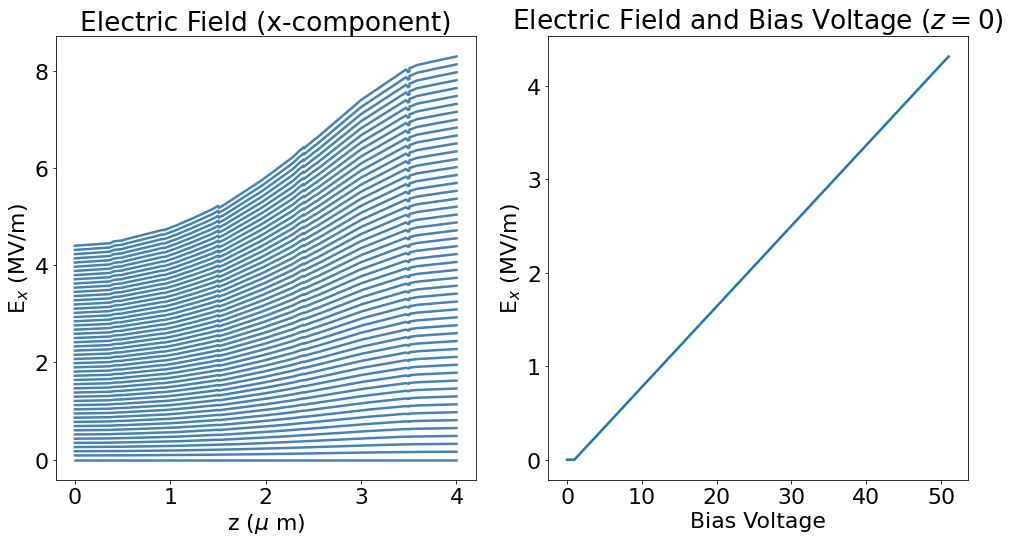

In [123]:
fig = plt.figure(figsize=(14,8))

ax0 = fig.add_subplot(121)
for v in vb:
    ex = str(v) + 'V'
    ax0.plot(Ex['cut_length_um'],Ex[ex]*1e-06, color='steelblue')
ax0.set_xlabel('z ($\mu$ m)')
ax0.set_ylabel('E$_{x}$ (MV/m)')
ax0.set_title('Electric Field (x-component)')

ax1 = fig.add_subplot(122)
ax1.plot(vb,[e * 1e-06 for e in Ex_z0um])
ax1.set_xlabel('Bias Voltage')
ax1.set_ylabel('E$_{x}$ (MV/m)')
ax1.set_title('Electric Field and Bias Voltage ($z{=}0$)')

plt.tight_layout()
plt.show()

# Spin Hamiltonian Calculations 

In [217]:
nvspin = SpinHamiltonian()

# nvspin.spin_hamiltonian()
B = np.linspace(0,0.2,len(Ex_z0um))
B0 = np.linspace(0,0,len(Ex_z0um))
Btheta = 0
BzFlag = 0

E = Ex_z0um
Etheta = 0
EzFlag = 0
freqspar = nvspin.transition_frequencies(B, Btheta, BzFlag, E, Etheta, EzFlag)
freqspar_electronic = nvspin.transition_frequencies(B0, Btheta, BzFlag, E, Etheta, EzFlag)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 9.56666667e+08  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.91333333e+09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  9.56666667e+08]]
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 9.56666667e+08  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.91333333e+09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  9.56666667e+08]]
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 9.56666667e+08  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.91333333e+09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  9.56666667e+08]]
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 9.56666667e+08  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.91333333e+09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  9.56666667e+08]]
Quantum object: dims = [

In [129]:
# nvspin.spin_hamiltonian()
B = np.linspace(0,0.2,len(Ex_z0um))
B0 = np.linspace(0,0,len(Ex_z0um))
Btheta = 0
BzFlag = 1

E = Ex_z0um
Etheta = 0
EzFlag = 1
freqsperp = nvspin.transition_frequencies(B, Btheta, BzFlag, E, Etheta, EzFlag)
freqsperp_electronic = nvspin.transition_frequencies(B0, Btheta, BzFlag, E, Etheta, EzFlag)

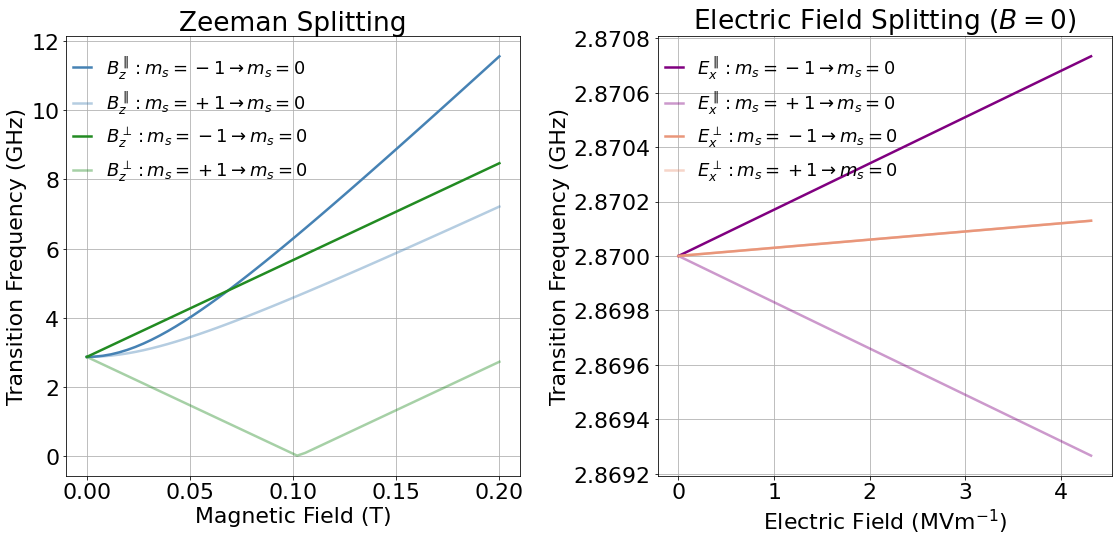

In [159]:
fig = plt.figure(figsize=(16,8))

ax0 = fig.add_subplot(121)
ax0.plot(B,freqspar[:,0].flatten()*1e-09, color='steelblue', alpha=1, label='$B_{z}^{\parallel}: m_{s}=-1 \\rightarrow m_{s}=0$') 
ax0.plot(B,freqspar[:,1].flatten()*1e-09, color='steelblue', alpha=.4, label='$B_{z}^{\parallel}:  m_{s}=+1 \\rightarrow m_{s}=0$')
ax0.plot(B,freqsperp[:,0].flatten()*1e-09, color='forestgreen', alpha=1, label='$B_{z}^{\perp}: m_{s}=-1 \\rightarrow m_{s}=0$') 
ax0.plot(B,freqsperp[:,1].flatten()*1e-09, color='forestgreen', alpha=.4, label='$B_{z}^{\perp}: m_{s}=+1 \\rightarrow m_{s}=0$')
ax0.legend(frameon=False, fontsize=18, handlelength=1, loc=(0,.65))
ax0.set_xlabel('Magnetic Field (T)')
ax0.set_ylabel('Transition Frequency (GHz)')
ax0.set_title('Zeeman Splitting')
ax0.grid()

ax1 = fig.add_subplot(122)
ax1.plot([e*1e-06 for e in E],freqspar_electronic[:,0].flatten()*1e-09, color='purple', alpha=1, label='$E_{x}^{\parallel}: m_{s}=-1 \\rightarrow m_{s}=0$') 
ax1.plot([e*1e-06 for e in E],freqspar_electronic[:,1].flatten()*1e-09, color='purple', alpha=.4, label='$E_{x}^{\parallel}:  m_{s}=+1 \\rightarrow m_{s}=0$')
ax1.plot([e*1e-06 for e in E],freqsperp_electronic[:,0].flatten()*1e-09, color='darksalmon', alpha=1, label='$E_{x}^{\perp}: m_{s}=-1 \\rightarrow m_{s}=0$') 
ax1.plot([e*1e-06 for e in E],freqsperp_electronic[:,1].flatten()*1e-09, color='darksalmon', alpha=.4, label='$E_{x}^{\perp}: m_{s}=+1 \\rightarrow m_{s}=0$')
ax1.legend(frameon=False, fontsize=18, handlelength=1, loc=(0,.65))
ax1.set_xlabel('Electric Field (MVm$^{-1}$)')
ax1.set_ylabel('Transition Frequency (GHz)')
ax1.set_title('Electric Field Splitting ($B{=}0$)')
ax1.grid()

plt.tight_layout()
plt.savefig('figs/isolated_spin_zeeman_and_electronic.png', bbox_inches="tight")
plt.show()

In [142]:
zfs = freqspar_electronic[:,0][0]

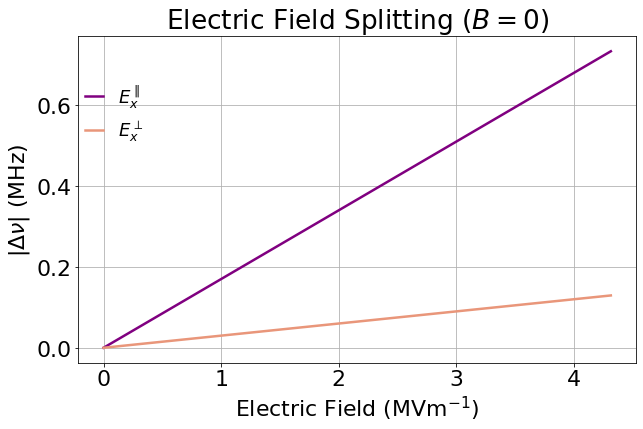

In [161]:
fig = plt.figure()

plt.plot([e*1e-06 for e in E],(freqspar_electronic[:,0]-zfs)*1e-06, color='purple', alpha=1, label='$E_{x}^{\parallel}$') 
plt.plot([e*1e-06 for e in E],(freqsperp_electronic[:,0]-zfs)*1e-06, color='darksalmon', alpha=1, label='$E_{x}^{\perp}$') 
plt.legend(frameon=False, fontsize=18, handlelength=1, loc=(0,.65))
plt.xlabel('Electric Field (MVm$^{-1}$)')
plt.ylabel('$|\\Delta \\nu|$ (MHz)')
plt.title('Electric Field Splitting ($B{=}0$)')
plt.grid()

plt.savefig('figs/isolated_spin_electronic_delta_freq.png', bbox_inches="tight")
plt.show()

In [212]:
class HyperfineSpinHamiltonian(SpinHamiltonian):
    def __init__(self):
        SpinHamiltonian.__init__(self)
        self.gc = 10.705e6                  # gyromagnetic ratio of C-13 nucleus in Hz/T for hyperfine interaction

        self.Axx = 189.3e6
        self.Ayy = 128.4e6
        self.Azz = 128.9e6
        self.Axz = 24.1e6                   # Hyperfine Tensor components in NV frame of reference. Taken from reference 2.
        self.Ix = qt.jmat(1,'x')
        self.Iy = qt.jmat(1,'y')
        self.Iz = qt.jmat(1,'z')            # Spin 1/2 operators for C-13 nucleus

        self.comp1 = self.Axx*qt.tensor(self.sx,self.Ix)
        self.comp2 = self.Ayy*qt.tensor(self.sy,self.Iy)
        self.comp3 = self.Azz*qt.tensor(self.sz,self.Iz)
        self.comp4 = self.Axz*(qt.tensor(self.sx,self.Iz)+qt.tensor(self.sz,self.Ix))
        self.Hhf = self.comp1 + self.comp2 + self.comp3 + self.comp4

        self.zero_field = self.D*(qt.tensor(self.sz*self.sz,qt.qeye(3))-(2/3)*qt.tensor(qt.qeye(3),qt.qeye(3)))
        
    def hyperfine_interaction(self,Bz):
        H = self.gc*Bz*qt.tensor(qt.qeye(3),self.Iz) + self.Hhf  
        return H.eigenstates()

    def interaction_with_field(self, Bz, E, Etheta, EzFlag):
        """ CHANGE THIS TO CALL OTHER CLASSES """
#         import pdb; pdb.set_trace()
#         H = (self.D*(qt.tensor(self.sz*self.sz,qt.qeye(3))-(2/3)*qt.tensor(qt.qeye(3),qt.qeye(3))) + 
#              self.ge*Bz*qt.tensor(self.sz,qt.qeye(3)) + 
#              self.hyperfine_interaction(BzFlag)[1] + 
#              self.electronic_interaction(E, Etheta, EzFlag))
#         H = (self.zero_field + 
#              self.ge*Bz*qt.tensor(self.sz,qt.qeye(3)) + 
#              self.electronic_interaction(E, Etheta, EzFlag))
        print(self.ge*Bz*qt.tensor(self.sz,qt.qeye(3)))
#         return H[0]

    def transition_freqs(self, BzFlag, E, Etheta, EzFlag):
        egvals = self.interaction_with_field(BzFlag, E, Etheta, EzFlag)[0]
        ms0 = (egvals[0] + egvals[1] + egvals[2])/3		# energy of 0 level averaged for simpler graph
        return np.array([egvals[3]-ms0, egvals[4]-ms0, egvals[5]-ms0, egvals[6]-ms0, egvals[7]-ms0, egvals[8]-ms0])

In [213]:
ham = HyperfineSpinHamiltonian()

# Plotting Hyperfine Resonant frequencies
def plotter_resonance(E, Etheta, EzFlag): 
    # generating all possible frequencies
    reso = np.full((18),1)
    freq = []
    egsts = ham.transition_freqs(1.199e-4, E, Etheta, EzFlag)
    for i in range (3):
        for j in range (3,9):
            freq.append(egsts[j]-egsts[i])
    freq = np.sort(freq)*0.000000001

    # plot first 6 frequencies
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    ax1.set_ylabel('Resonant Amplitude',fontsize=12)
    ax1.set_title("Resonant Frequencies")
    ax1.bar(freq[0:6],reso[0:6],width=0.00003,bottom=None)

    # plot next 6 frequencies
    ax2 = fig.add_subplot(312)
    ax2.set_ylabel('Resonant Amplitude',fontsize=12)
    ax2.bar(freq[6:12],reso[0:6],width=0.00003,bottom=None)

    # plot next 6 frequencies
    ax3 = fig.add_subplot(313)
    ax3.set_xlabel('Frequency in GHz',fontsize=12)
    ax3.set_ylabel('Resonant Amplitude',fontsize=12)
    ax3.bar(freq[12:18],reso[0:6],width=0.00003,bottom=None)
    plt.show()

In [214]:
if __name__=="__main__":
    plotter_resonance(E, Etheta, EzFlag)
#     BvsF_plotter()

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 3357200.        0.        0.        0.        0.        0.        0.
         0.        0.]
 [       0.  3357200.        0.        0.        0.        0.        0.
         0.        0.]
 [       0.        0.  3357200.        0.        0.        0.        0.
         0.        0.]
 [       0.        0.        0.        0.        0.        0.        0.
         0.        0.]
 [       0.        0.        0.        0.        0.        0.        0.
         0.        0.]
 [       0.        0.        0.        0.        0.        0.        0.
         0.        0.]
 [       0.        0.        0.        0.        0.        0. -3357200.
         0.        0.]
 [       0.        0.        0.        0.        0.        0.        0.
  -3357200.        0.]
 [       0.        0.        0.        0.        0.        0.        0.
         0. -3357200.]]


TypeError: 'NoneType' object is not subscriptable

In [ ]:
ham = HyperfineSpinHamiltonian()

# Plotting Hyperfine Resonant frequencies
def plotter_resonance(): 
    # generating all possible frequencies
    reso = np.full((18),1)
    freq = []
    egsts = ham.eigenvalues(1.199e-4)
    for i in range (3):
        for j in range (3,9):
            freq.append(egsts[j]-egsts[i])
    freq = np.sort(freq)*0.000000001

    # plot first 6 frequencies
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    ax1.set_ylabel('Resonant Amplitude',fontsize=12)
    ax1.set_title("Resonant Frequencies")
    ax1.bar(freq[0:6],reso[0:6],width=0.00003,bottom=None)

    # plot next 6 frequencies
    ax2 = fig.add_subplot(312)
    ax2.set_ylabel('Resonant Amplitude',fontsize=12)
    ax2.bar(freq[6:12],reso[0:6],width=0.00003,bottom=None)

    # plot next 6 frequencies
    ax3 = fig.add_subplot(313)
    ax3.set_xlabel('Frequency in GHz',fontsize=12)
    ax3.set_ylabel('Resonant Amplitude',fontsize=12)
    ax3.bar(freq[12:18],reso[0:6],width=0.00003,bottom=None)
    plt.show()
    
#Plotting ms=0 to ms=1 transition frequency as a function of magnetic field for hyperfine Hamiltonian
def BvsF_plotter():
    # B covers fields until the point where ms=-1 does not fall below ms=0
    # Bzoom is for the zoomed graph			
    hpham = np.vectorize(ham.transitionFreqs, otypes=[np.ndarray])
    Bz = np.linspace(0,1e-2,100)
    Bzoom = np.linspace(0,5e-3,100)
    freqs = np.array(hpham(Bz))
    freqs = np.array(freqs.tolist())
    freqs_zoom = np.array(hpham(Bzoom))
    freqs_zoom = np.array(freqs_zoom.tolist())

    #Qutip by default arranges eigenvalues in sorted order. This never gives a negative frequency. So the graph has to be extended logically.
    #calculating slope array
    b1 = 1e-2
    f1 = hpham(b1)
    b2 = 0.8e-2
    f2 = hpham(b2)
    m = (f2-f1)/(b2-b1)

    #adding higher magnetic field values
    Bzext = np.linspace(1e-2,0.2,200)
    fext = np.absolute(np.outer(Bzext-b1,m) + f1)

    #appending B and f arrays
    Bz = np.append(Bz,Bzext)
    freqs = np.append(freqs,fext,axis=0)

    fig = plt.figure()
    ax = plt.subplot2grid((5,5),(0,0),rowspan=5,colspan=3)  # for proper sizing and placement of graph
    ax.set_xlabel("Magnetic Field (T)",fontsize=12)
    ax.set_ylabel("Transition Frequency (GHz)", fontsize=12)
    ax.set_title("Transition frequencies vs Magnetic field")
    ax.plot(Bz,freqs[:,0],label="$m_{s}=-1$, $m_{I}=+1$ \u2192 $m_{s}=0$") 
    ax.plot(Bz,freqs[:,1],label="$m_{s}=-1$, $m_{I}=0$ \u2192 $m_{s}=0$") 
    ax.plot(Bz,freqs[:,2],label="$m_{s}=-1$, $m_{I}=-1$ \u2192 $m_{s}=0$") 
    ax.plot(Bz,freqs[:,3],label="$m_{s}=+1$, $m_{I}=-1$ \u2192 $m_{s}=0$") 
    ax.plot(Bz,freqs[:,4],label="$m_{s}=+1$, $m_{I}=0$ \u2192 $m_{s}=0$") 
    ax.plot(Bz,freqs[:,5],label="$m_{s}=+1$, $m_{I}=+1$ \u2192 $m_{s}=0$") 
    ax.legend(loc='upper left',fontsize=8,labelspacing=0)
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    axz = plt.subplot2grid((5,5),(0,3),rowspan=5,colspan=2)  # for proper sizing and placement of graph
    axz.set_xlabel("Magnetic Field (T)",fontsize=12)
    axz.set_title("Zoomed Graph")
    axz.plot(Bzoom,freqs_zoom[:,0],label="$m_{s}=-1$, $m_{I}=+1$ \u2192 $m_{s}=0$") 
    axz.plot(Bzoom,freqs_zoom[:,1],label="$m_{s}=-1$, $m_{I}=0$ \u2192 $m_{s}=0$") 
    axz.plot(Bzoom,freqs_zoom[:,2],label="$m_{s}=-1$, $m_{I}=-1$ \u2192 $m_{s}=0$") 
    axz.plot(Bzoom,freqs_zoom[:,3],label="$m_{s}=+1$, $m_{I}=-1$ \u2192 $m_{s}=0$") 
    axz.plot(Bzoom,freqs_zoom[:,4],label="$m_{s}=+1$, $m_{I}=0$ \u2192 $m_{s}=0$") 
    axz.plot(Bzoom,freqs_zoom[:,5],label="$m_{s}=+1$, $m_{I}=+1$ \u2192 $m_{s}=0$")
    axz.locator_params(axis='x', nbins=4)  			# to reduce crowding of ticks
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    plt.tight_layout()
    plt.show()
    
if __name__=="__main__":
    plotter_resonance()
    BvsF_plotter()